In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.decomposition.asf import ASF
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot

In [2]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")

Resulting directory path: D:/work/projects/mechanism_builder/results/first_setup/topology_7_2024-07-19_17-16-41


In [3]:
problem = MultiCriteriaProblem.load(
    selected_directory
)

checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

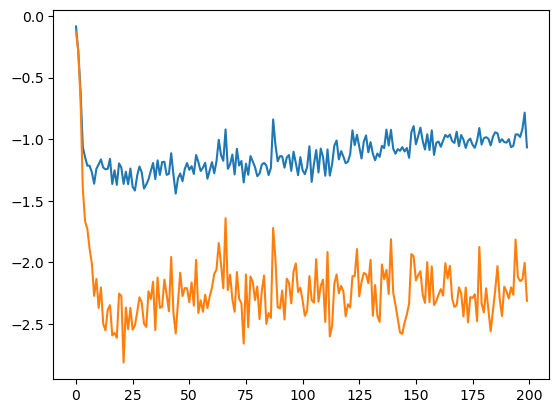

In [4]:
history_mean = optimizer.history["Mean"]
plt.plot(np.arange(len(history_mean)), history_mean)
plt.show()


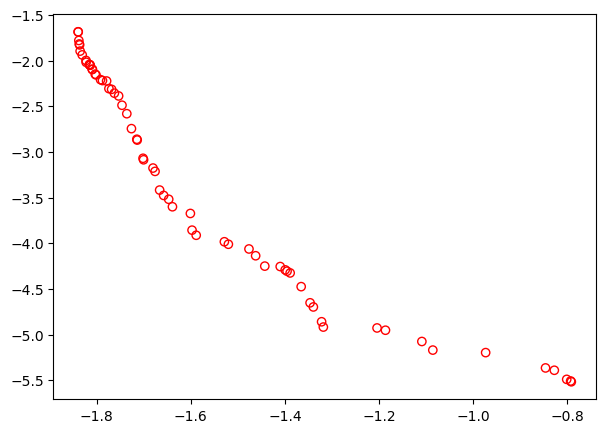

In [5]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, )
ax.scatter(F[:, 0], F[:, 1],  facecolors='none', edgecolors='r')

In [6]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)


Scale f1: [-1.839630166689555, -0.7910208106040955]
Scale f2: [-5.517005578523096, -1.6840395471325316]


Best regarding ASF: 
F = [-1.36538911 -4.47514278]


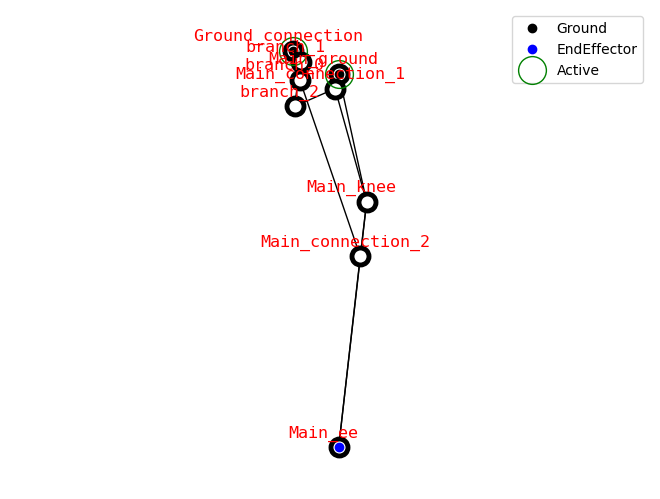

In [7]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.4, 0.6])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
print(f"Best regarding ASF: \nF = {F[b]}")
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

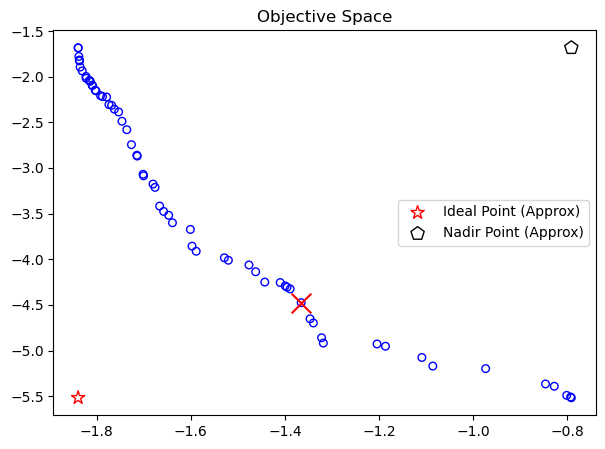

In [8]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.scatter(F[b, 0], F[b, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.legend()
plt.show()

In [9]:
histF = np.array(optimizer.history["F"])
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 0.773984375


In [10]:
worstF1_id = np.argmax(validF1)
worstF2_id = np.argmax(validF2)
worst_reward2 = validF2[worstF2_id]
worst_reward1 = validF1[worstF1_id]
print('The maximum result in optimization task:', worst_reward1, worst_reward2)

The maximum result in optimization task: -0.5364977121353149 -0.2559455487879686


In [11]:
bestF1_id = np.argmin(validF1)
bestF2_id = np.argmin(validF2)
bestF1_x = optimizer.history["X"][np.where(histF[:,0]==validF1[bestF1_id])[0][0]]
bestF1_reward = validF1[bestF1_id]
bestF2_x = optimizer.history["X"][np.where(histF[:,1]==validF2[bestF2_id])[0][0]]
bestF2_reward = validF2[bestF2_id]
print("The minimum result in optimization task: F1:", bestF1_reward, " F2: ", bestF2_reward, f" F: weights: {weights}", F[b])

The minimum result in optimization task: F1: -1.839630166689555  F2:  -5.517005578523096  F: weights: [0.4 0.6] [-1.36538911 -4.47514278]


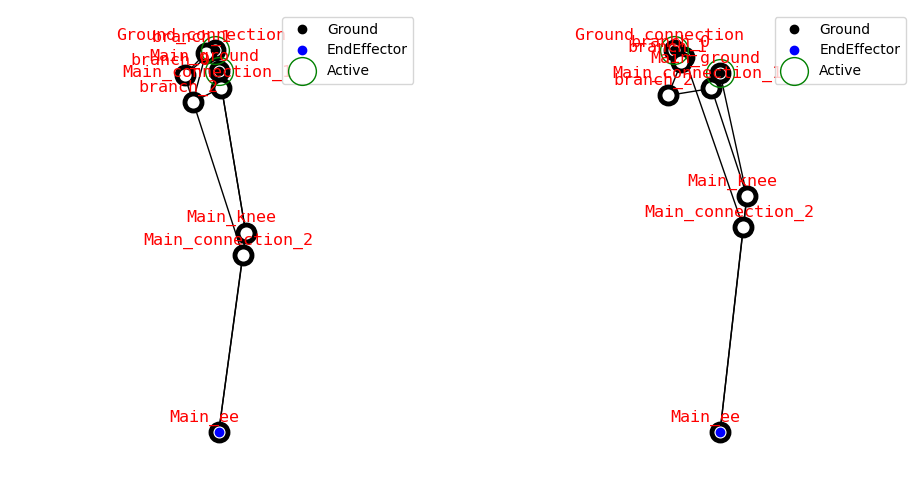

In [12]:
gm = problem.graph_manager
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
graph = gm.get_graph(bestF1_x)
draw_joint_point(graph)
plt.subplot(1, 3, 2)
graph = gm.get_graph(bestF2_x)
draw_joint_point(graph)


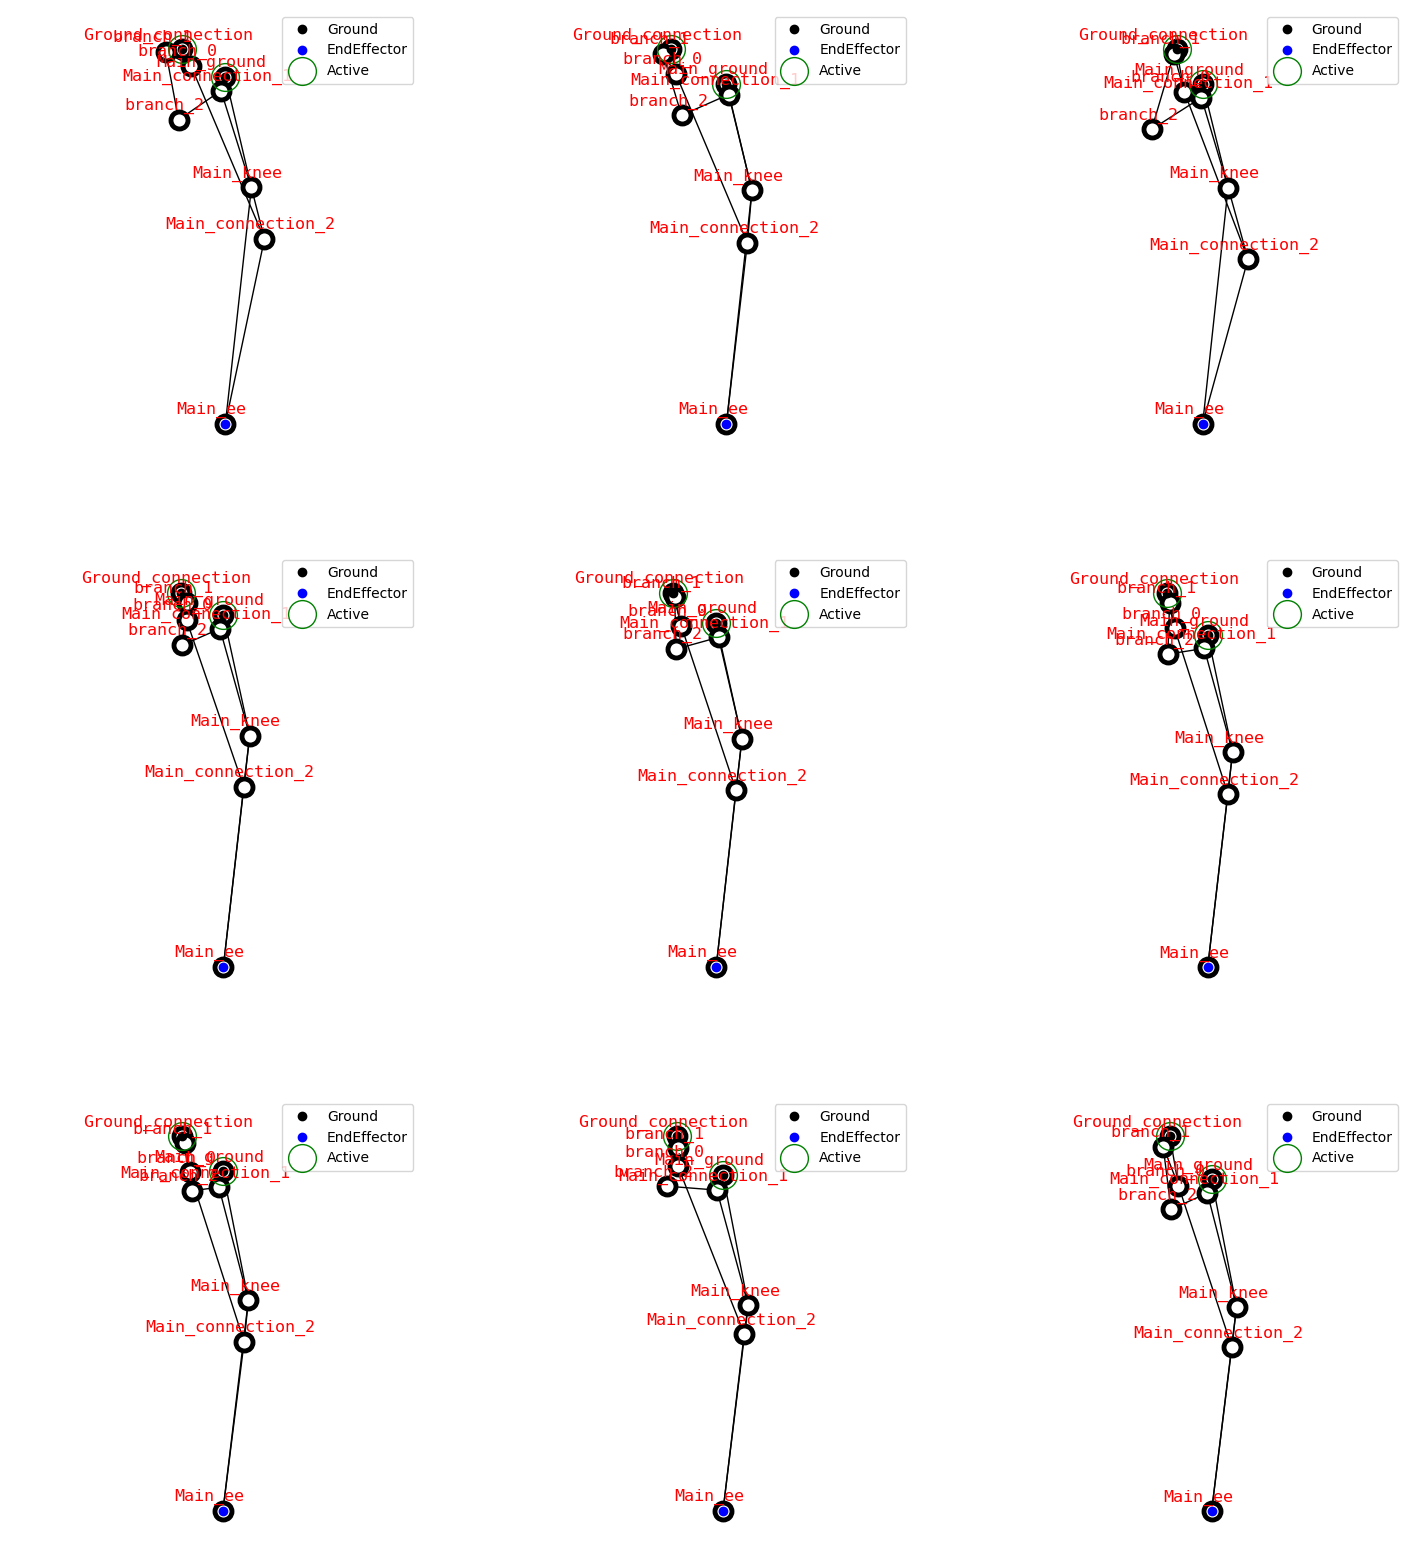

In [13]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights_vector = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(18, 20))
for i, w in enumerate(weights_vector):
    weights = np.array([w, 1-w])
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]
    graph = problem.graph_manager.get_graph(best_x)
    plt.subplot(3, 3, i+1)
    draw_joint_point(graph)

plt.show()

In [14]:
histF = res.F
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 1.0


In [15]:
len(res.F)

64

In [16]:
# from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
# thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
# actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
# density = MIT_CHEETAH_PARAMS_DICT["density"]
# body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


# builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
#                               density={"default": density, "G": body_density},
#                               thickness={"default": thickness, "EE": 0.033},
#                               actuator={"default": actuator},
#                               size_ground=np.array(
#                                   MIT_CHEETAH_PARAMS_DICT["size_ground"]),
#                               offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
#                               )

# from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
# from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
# from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
# from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
# from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability

# ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

# ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

# ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))


# central_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-0.32, 0.075, 0, 50))

# left_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

# right_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))
# # 2) characteristics to be calculated
# # criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
# dict_trajectory_criteria = {
#     "MASS": NeutralPoseMass(),
# }
# # criteria calculated for each point on the trajectory
# dict_point_criteria = {
#     "Effective_Inertia": EffectiveInertiaCompute(),
#     "Actuated_Mass": ActuatedMass(),
#     "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
# }
# # special object that calculates the criteria for a robot and a trajectory
# crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# # set the rewards and weights for the optimization task
# acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
#                                                     trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# heavy_lifting = HeavyLiftingReward(
#     manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# # set up special classes for reward calculations
# error_calculator = PositioningErrorCalculator(
#     error_key='error', jacobian_key="Manip_Jacobian")
# # soft_constrain = PositioningConstrain(
# #     error_calculator=error_calculator, points=[workspace_trajectory])
# sf = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
#                                                                                    ground_symmetric_step2,
#                                                                                    ground_symmetric_step3,
#                                                                                    central_vertical,
#                                                                                    left_vertical,
#                                                                                    right_vertical])

# # manager should be filled with trajectories and rewards using the manager API
# reward_manager = RewardManager(crag=crag)
# reward_manager.add_trajectory(ground_symmetric_step1, 0)
# reward_manager.add_trajectory(ground_symmetric_step2, 1)
# reward_manager.add_trajectory(ground_symmetric_step3, 2)

# reward_manager.add_trajectory(central_vertical, 3)
# reward_manager.add_trajectory(left_vertical, 4)
# reward_manager.add_trajectory(right_vertical, 5)

# reward_manager.add_reward(acceleration_capability, 0, 1)
# reward_manager.add_reward(acceleration_capability, 1, 1)
# reward_manager.add_reward(acceleration_capability, 2, 1)

# reward_manager.add_reward(heavy_lifting, 3, 1)
# reward_manager.add_reward(heavy_lifting, 4, 1)
# reward_manager.add_reward(heavy_lifting, 5, 1)

# reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
# reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [17]:
import pinocchio as pin
pin.seed(3)
sf = problem.soft_constrain
builder = problem.builder
crag = problem.rewards_and_trajectories.crag
# trajectory = problem.rewards_and_trajectories.trajectories[1]

counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 4)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-1.18617082 -4.95241744] [1.1861883401870728, 4.604315969346705]
[-1.08549821 -5.16988933] [0.7180053194363912, 5.169825191014357]
[-1.10879268 -5.07581119] [1.1087926824887593, 5.0758111920667]
[-1.44275339 -4.25035136] [1.4427533944447835, 4.25035136275771]
[-0.97315339 -5.19758952] [1.0864564180374146, 5.197550042051691]
[-1.40995979 -4.25502849] [1.4098596572875977, 3.678026767943083]
[-1.70047653 -3.08585434] [1.7004765272140503, 3.0858543351921384]
[-1.33949574 -4.69763598] [1.339520255724589, 3.4750931847164623]
[-1.68041686 -3.17639611] [1.6804837385813396, 2.486415506004503]
[-1.70160965 -3.06931494] [1.7016096512476604, 3.069314938401881]
[-1.60096796 -3.67365433] [1.6009679635365803, 3.6736543321266226]
[-1.73613298 -2.58122482] [1.7361329793930054, 2.581224823807428]
[-1.47638766 -4.06252863] [1.476387659708659, 4.062528627888257]
[-1.83645582 -1.8277096 ] [1.836434245109558, 1.827657578488532]
[-1.76844676 -2.31452835] [1.7684467633565266, 2.3145283518159556]
[-1.63910155

0

In [18]:
F = np.array(optimizer.history["F"])
X = np.array(optimizer.history["X"])
Fs = np.array(optimizer.history["Fs"])
idx=np.where(F[:,0]==res.F[0][0])[0][0]
idx

4567

In [19]:
x = X[idx]
x

array([-0.06547602,  0.04052571, -0.12553345,  0.07721522,  0.39928427,
       -0.00366374,  0.27501522, -0.08429894,  0.1998415 , -0.01464884,
       -0.0037832 , -0.05550332, -0.03418123])

In [20]:
Fs[idx]

array([1.13421702, 1.19132757, 1.23296785, 6.10651669, 4.44486026,
       4.30587539])

In [28]:
x = np.round(X[idx],4)
print(x)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
#point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

if constrain_error>0:
    print(constrain_error)
    counter+=1
#else:
__, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
print(F[idx], vector_rewards, '\n', partial_rewards)

[-0.0655  0.0405 -0.1255  0.0772  0.3993 -0.0037  0.275  -0.0843  0.1998
 -0.0146 -0.0038 -0.0555 -0.0342]
[-1.18617082 -4.95241744] [1.1861883401870728, 4.604315969346705] 
 [1.1342361, 1.1913456, 1.2329834, 5.062250206293119, 4.444819331242689, 4.305878370504307]


In [22]:
for i in range(3,8):    
    x = np.round(X[idx],i)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.2066702842712402, 4.292056757634318] 
 [1.1581799, 1.211275, 1.250556, 5.0384111598625765, 4.315628552822878, 3.522130560217497]
[1.1861883401870728, 4.604315969346705] 
 [1.1342361, 1.1913456, 1.2329834, 5.062250206293119, 4.444819331242689, 4.305878370504307]
[1.1862259308497112, 4.345506086508681] 
 [1.1342363, 1.1913879, 1.2330536, 5.0628204136953965, 4.443963657082416, 3.5297341887482334]
[1.1861510674158733, 4.345657409787081] 
 [1.1341479, 1.1913152, 1.2329901, 5.062806602628353, 4.444467610525059, 3.529698016207829]
[1.1861740748087566, 4.345591029873133] 
 [1.1341757, 1.1913373, 1.2330092, 5.062726680231211, 4.444361577187444, 3.5296848322007435]


In [23]:
import random 
for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.13

In [24]:
import random 
for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.1341739, 1.1913357, 1.2330078, 5.0627311255957315, 4.444368954815697, 4.3068834385534185]
[1.1861724456151326, 4.6046611729882825] 
 [1.13

In [25]:
Fs[idx]

array([1.13421702, 1.19132757, 1.23296785, 6.10651669, 4.44486026,
       4.30587539])

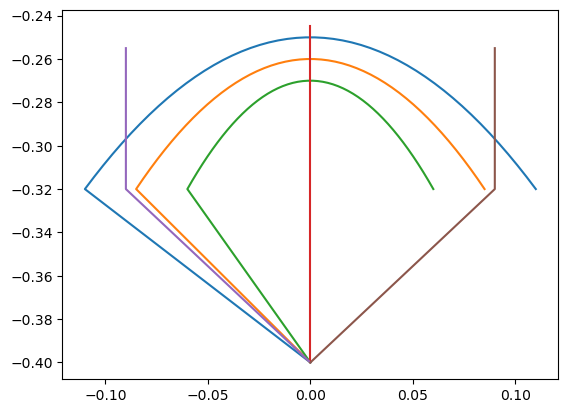

In [26]:
for _, trajectory in problem.rewards_and_trajectories.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])


plt.show()

In [27]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat
trajectory = problem.rewards_and_trajectories.trajectories[5]
x= np.round(X[idx],4)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
crag.get_criteria_data(fixed_robot, free_robot, trajectory,viz)
#calculate_quasi_static_simdata(free_robot, fixed_robot,'EE', trajectory, viz=viz)
pass

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
